#### Climbing Grade Prediction: Processing the dataset
Loading the dataset

In [166]:
import pandas as pd
import numpy as np

init_data = pd.read_csv("powerCompany.csv")
init_data.head()

,age,sex,max_boulder,max_sport,exp,trainexp,country,state,rock,season,...,continuous,maxhang,weightedpull,repeaters1,longcamp,shortcamp,ohpr,ohll,dl,bmi_score
0,43,Female,<V3,5.10c/d,>10 years,<1 year,United States,KY,Sandstone,7-9 months,...,16,37.0,10.0,31.0,41.0,62.0,NaN,NaN,NaN,25.1
1,16,Female,V6,5.12c/d,7-8 years,7-8 years,US,Montana,Limestone,4-6 months,...,28,10.0,20.0,120.0,NaN,NaN,15.0,15.0,110.0,21.5
2,19,Male,V9,5.13c/d,>10 years,7-8 years,Usa,Georgia,Sandstone,4-6 months,...,54,35.0,85.0,117.0,114.0,301.0,NaN,NaN,NaN,22.2
3,34,Male,V8,5.12a/b,>10 years,5-6 years,USA,North Carolina,Granite,4-6 months,...,47,50.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,25.1
4,30,Female,V8,5.12a/b,7-8 years,3-4 years,US,Washington,Granite,4-6 months,...,NaN,35.0,25.0,NaN,95.0,210.0,25.0,25.0,145.0,21.6


Converting all easily translatable columns to numeric, including our target variable

In [167]:
df_cols = ["boulder_num", "days", "season", "age", "sex_int", "height", "weight", "span", "exp_transformed", "trainexp_transformed", "maxhang", "weightedpull", "pullup", "pushup"]

# convert the V grade input to a number grade. We are going to cap the system at V13+ since there are not enough observations
grade_dict = {"<V3":3, "V4":4,"V5":5,"V6":6,"V7":7,"V8":8,"V9":9,"V10":10,
              "V11":11, "V12":12,"V13":13,"V14":13,"V15":13,"V16":13,"V17":13,
              "I have not pursued bouldering goals outside in the past year": 0
             }

# convert experience to a number
experience_dict = { "< 1 year":0,"<1 year":0,"1-2 years":1,"3-4 years":3,"5-6 years":5,"7-8 years":7,
                   "9-10 years":9, ">10 years":11, "> 10 years":11
                  }

# make the gender a dummy var
sex_dict = {"Male": 0, "Female": 1, "Other/Prefer to Not Answer": np.NaN, '0': np.NaN, 'Other': np.NaN}

season_dict = {"1-3 months": 3,
            "4-6 months": 6, 
             "7-9 months": 9,
             "Year round": 12
            }

# set up our bouldering data
bouldering_only = init_data.copy()
bouldering_only["boulder_num"] = bouldering_only.max_boulder.map(grade_dict)
bouldering_only["exp_transformed"] = bouldering_only.exp.map(experience_dict)
bouldering_only["trainexp_transformed"] = bouldering_only.trainexp.map(experience_dict)
bouldering_only["sex_int"] = bouldering_only.sex.map(sex_dict)

bouldering_only = bouldering_only[df_cols]
# we only care about people who boulder
bouldering_only = bouldering_only[bouldering_only.boulder_num > 0]

Extra preprocessing has to be done with the "days" column.

In [168]:
# convert days to fully numeric
days_dict = {'3-4 days per month':3, '5-6 days per month':5, '1-5 days per month':3,
       '7-8 days per month':7, '>10 days per month':11, '>15 days per month':16, '9-10 days per month':9, 'I currently do no climb outdoors':0.0, np.nan:0.0}

# convert days to fully numeric by multiplying days per month by season length
bouldering_only["days"] = pd.to_numeric(bouldering_only.days.replace(days_dict))
bouldering_only.season = pd.to_numeric(bouldering_only.season.replace(season_dict))

# after this date they seem to have collected days per year instead of days per month, so we convert
bouldering_only.loc[36:, "days"] /= bouldering_only.loc[36:, "season"].values

Visualize the data, to begin processing

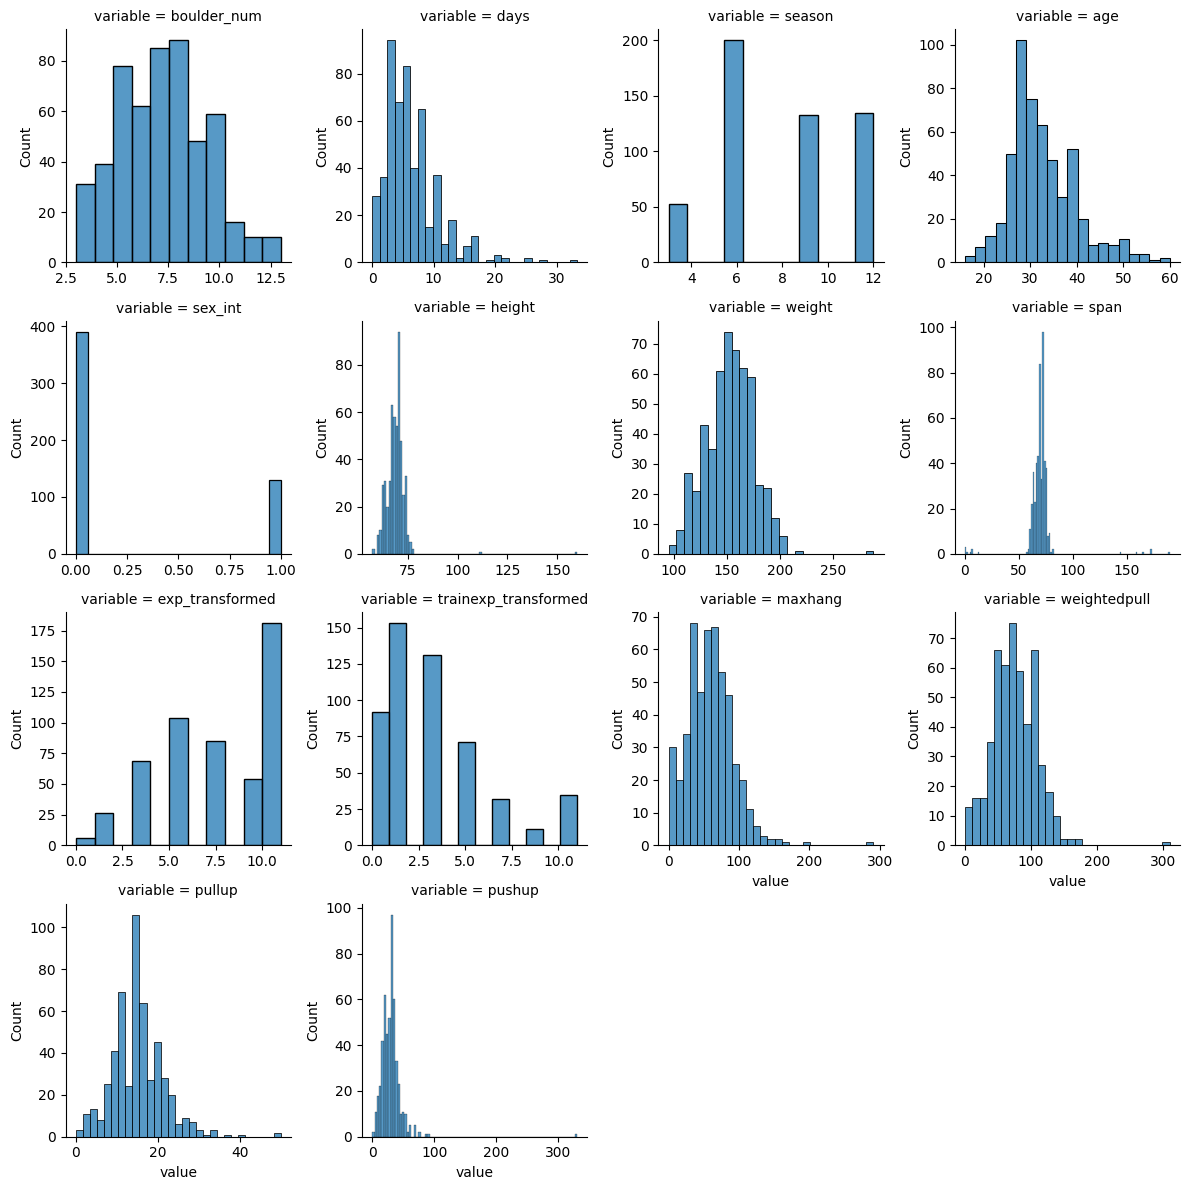

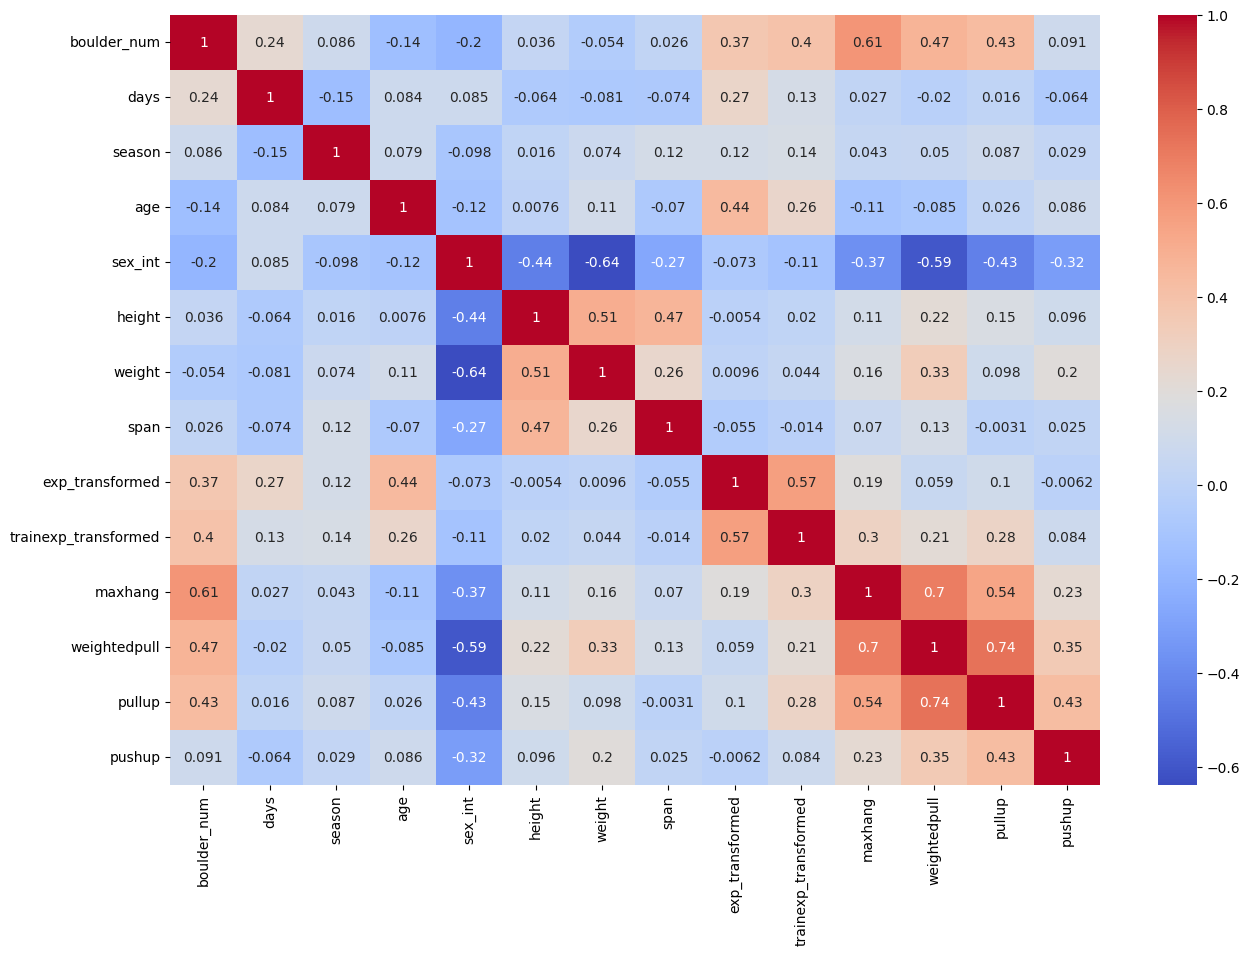

In [169]:
# plot our values
import seaborn as sns
import matplotlib.pyplot as plt
quant_feat = bouldering_only.columns.values

f = pd.melt(bouldering_only, value_vars=quant_feat)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")
plt.show()

# plot our correlation
plt.figure(figsize=(15, 10)).tight_layout()
sns.heatmap(bouldering_only.corr(numeric_only = True), annot=True, cmap='coolwarm')
plt.show()

Now move through each column, identifying and accounting for problems found within the dataset

,boulder_num,days,season,age,sex_int,height,weight,span,exp_transformed,trainexp_transformed,maxhang,weightedpull,pullup,pushup
84,5.0,NaN,3.0,45,1.0,63.0,125.0,64.0,11.0,0.0,40.0,20.0,7.0,15.0
220,7.0,NaN,6.0,21,0.0,72.0,170.0,72.0,5.0,1.0,90.0,70.0,18.0,30.0
551,8.0,NaN,6.0,32,1.0,62.0,135.0,0.0,9.0,0.0,35.0,50.0,13.0,20.0
605,5.0,NaN,3.0,48,1.0,63.0,125.0,63.0,11.0,1.0,35.0,22.0,7.0,15.0


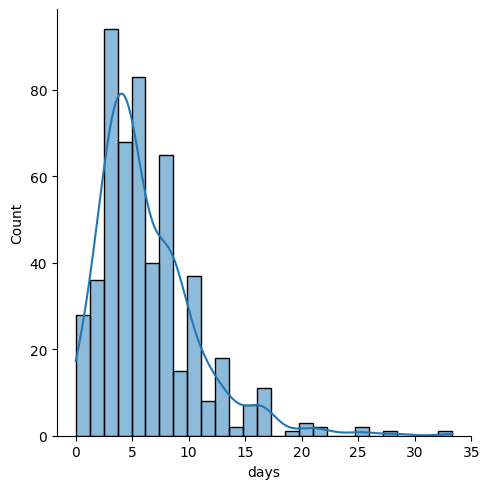

In [170]:
# start with the days variable
import scipy.stats as st
y = bouldering_only.days
sns.displot(y, kde=True)

day_filter = (bouldering_only.days >= 25) | (bouldering_only.age.isna())

# over 25 days a month every month for a season of over 3 months is extremely unlikely (since that would be 5 days on 1 day off, all outside)
# taking into consideration seasons longer than three months this is a practical impossibility
bouldering_only.loc[day_filter, "days"] = np.NaN
day_rows = bouldering_only[day_filter]
day_rows.head(20)

,boulder_num,days,season,age,sex_int,height,weight,span,exp_transformed,trainexp_transformed,maxhang,weightedpull,pullup,pushup
359,8.0,5.500000,12.0,56,0.0,75.0,179.0,6.2,11.0,11.0,110.0,125.0,50.0,75.0
409,8.0,4.444444,9.0,60,0.0,70.0,149.0,69.0,11.0,11.0,40.0,121.0,34.0,35.0
516,3.0,6.666667,3.0,59,1.0,65.0,148.0,65.0,11.0,0.0,0.0,0.0,0.0,11.0


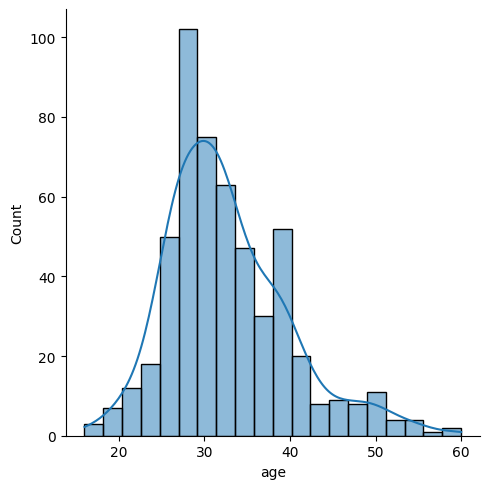

In [171]:
y = bouldering_only.age
sns.displot(y, kde=True)

age_rows = bouldering_only[(bouldering_only.age < 10) | (bouldering_only.age > 55) | (bouldering_only.age.isna())]
age_rows.head(20)

,boulder_num,days,season,age,sex_int,height,weight,span,exp_transformed,trainexp_transformed,maxhang,weightedpull,pullup,pushup
151,3.0,9.166667,6.0,42,0.0,111.0,153.0,173.0,11.0,3.0,17.0,25.0,9.0,18.0
218,6.0,NaN,NaN,38,NaN,NaN,175.0,NaN,NaN,NaN,55.0,62.0,NaN,NaN
247,8.0,3.333333,6.0,29,0.0,160.0,165.0,159.0,7.0,1.0,52.0,62.0,18.0,34.0
365,6.0,0.000000,6.0,28,NaN,NaN,155.0,74.0,3.0,1.0,60.0,65.0,15.0,40.0
586,5.0,NaN,NaN,33,0.0,NaN,154.0,NaN,7.0,1.0,110.0,44.0,11.0,32.0


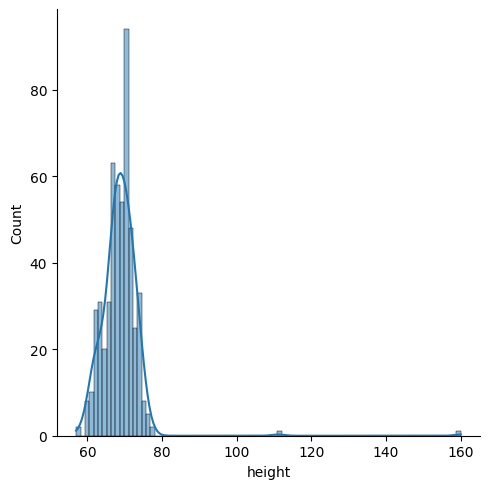

In [172]:
y = bouldering_only.height
sns.displot(y, kde=True)

height_rows = bouldering_only[(bouldering_only.height < 50) | (bouldering_only.height > 100) | (bouldering_only.height.isna())]
height_rows.head(20)


In [173]:
# very large heights look to be an issue with data entry, i.e. they put an extra 1 at the start of their input, or it is in cm instead of in
# best practice would be to set the height to their span or do some imputation

# we will wait on NaN values for now, since we may be able to impute them later with a better estimate
problem_rows = ((bouldering_only.height < 50) | (bouldering_only.height > 100))
bouldering_only.loc[(problem_rows), "height"] = np.NaN

,boulder_num,days,season,age,sex_int,height,weight,span,exp_transformed,trainexp_transformed,maxhang,weightedpull,pullup,pushup
16,3.0,3.0,6.0,43,0.0,70.0,288.0,NaN,1.0,0.0,0.0,0.0,0.0,10.0


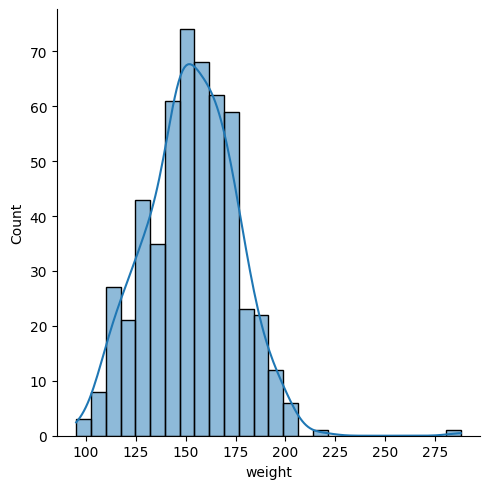

In [174]:
y = bouldering_only.weight
sns.displot(y, kde=True)

weight_rows = bouldering_only[((bouldering_only.weight < 50) | (bouldering_only.weight > 250))]
weight_rows.head(20)

,boulder_num,days,season,age,sex_int,height,weight,span,exp_transformed,trainexp_transformed,maxhang,weightedpull,pullup,pushup
5,3.0,16.000000,12.0,38,0.0,70.00,185.0,NaN,11.0,5.0,30.0,55.0,8.0,12.0
16,3.0,3.000000,6.0,43,0.0,70.00,288.0,NaN,1.0,0.0,0.0,0.0,0.0,10.0
35,8.0,7.000000,9.0,54,0.0,74.00,185.0,6.2,11.0,11.0,35.0,125.0,30.0,75.0
36,5.0,8.333333,9.0,47,0.0,66.00,140.0,NaN,11.0,0.0,NaN,NaN,NaN,NaN
53,5.0,3.888889,9.0,27,0.0,67.00,150.0,NaN,3.0,1.0,72.0,77.0,14.0,27.0
80,6.0,8.333333,12.0,34,0.0,69.00,148.0,144.0,9.0,5.0,85.0,NaN,NaN,NaN
134,10.0,16.666667,9.0,31,1.0,66.00,130.0,NaN,11.0,11.0,40.0,40.0,14.0,18.0
138,9.0,8.333333,12.0,27,0.0,71.00,175.0,172.5,9.0,3.0,70.0,100.0,10.0,38.0
151,3.0,9.166667,6.0,42,0.0,NaN,153.0,173.0,11.0,3.0,17.0,25.0,9.0,18.0
163,6.0,2.916667,12.0,32,0.0,70.00,176.0,NaN,5.0,3.0,40.0,70.0,12.0,31.0


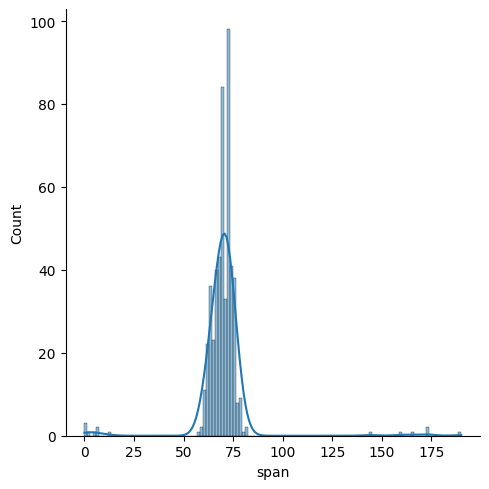

In [175]:
y = bouldering_only.span
sns.displot(y, kde=True)

# issue rows are rows with a span over 100 inches (96 in = 8 ft span) or under 50 inches (48 in = 4 ft span)
span_rows = bouldering_only[(bouldering_only.span < 50) | (bouldering_only.span > 100) | (bouldering_only.span.isna())]
span_rows.head(50)

In [176]:
# very small spans seem to be an issue with what the participants thought they were entering
# i.e. they thought span was ape index, and inputted +2 or +0, so we add the span to the height for their new span
bouldering_only.loc[(bouldering_only.span < 10), "span"] = bouldering_only.loc[(bouldering_only.span < 10), "height"]

# other errors we cannot be sure about, so best practice would be to set the span to their height or do some imputation
# this is what we will do with the rest of the values we cannot account for
# we will wait on NaN values for now, since we may be able to impute them later with a better estimate
problem_rows = ((bouldering_only.span < 50) | (bouldering_only.span > 100))
bouldering_only.loc[(problem_rows), "span"] = np.NaN

# check out our last outlier. +16 ape index is unheard of afaik so we will set it to nan to impute later as well
bouldering_only[(bouldering_only.span > 85)].head()
bouldering_only.loc[(bouldering_only.span > 85), "span"] = np.NaN

,boulder_num,days,season,age,sex_int,height,weight,span,exp_transformed,trainexp_transformed,maxhang,weightedpull,pullup,pushup
16,3.0,3.000000,6.0,43,0.0,70.00,288.0,NaN,1.0,0.0,0.0,0.0,0.0,10.0
76,4.0,5.000000,6.0,24,1.0,62.00,130.0,62.00,3.0,3.0,0.0,0.0,2.0,30.0
81,7.0,3.333333,6.0,27,1.0,61.00,115.0,60.00,5.0,3.0,0.0,30.0,6.0,7.0
92,3.0,2.500000,6.0,40,1.0,63.00,119.0,65.00,1.0,0.0,0.0,1.0,3.0,8.0
179,4.0,3.333333,6.0,26,1.0,68.00,140.0,66.00,5.0,0.0,0.0,25.0,9.0,20.0
180,3.0,2.083333,12.0,37,0.0,71.00,190.0,72.00,5.0,0.0,0.0,30.0,8.0,30.0
256,3.0,3.333333,6.0,26,1.0,63.50,95.0,NaN,0.0,0.0,0.0,15.0,4.0,15.0
312,4.0,5.000000,6.0,30,0.0,67.00,150.0,67.00,5.0,1.0,0.0,100.0,16.0,44.0
342,3.0,8.333333,3.0,28,1.0,66.00,156.0,66.00,3.0,1.0,0.0,15.0,4.0,9.0
396,5.0,8.333333,6.0,35,1.0,66.00,125.0,68.50,7.0,0.0,0.0,13.0,4.0,24.0


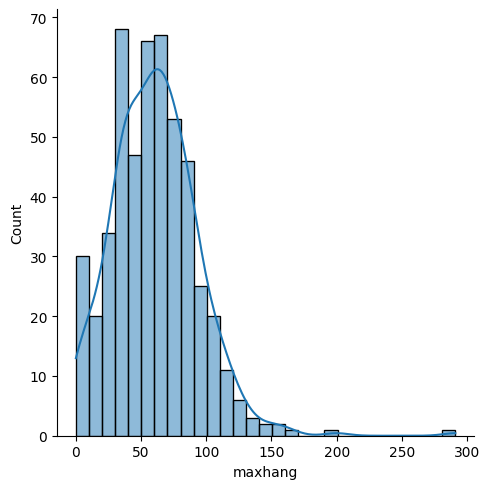

In [177]:
y = bouldering_only.maxhang
sns.displot(y, kde=True)

# now we take a look at the outliers and zeros
maxhang_rows = bouldering_only[(bouldering_only.maxhang == 0) | (bouldering_only.maxhang > 150)]
maxhang_rows.head(50)

In [178]:
# we note that row 465 doesn't allign well with their weightedpull and pullup numbers (310 lbs added is WR territory, but only 23 pullups?)
# seems like input was total weight rather than weight added, we adjust by subtracting by weight (124 lbs added for 23 pullups is much more in line)
bouldering_only.loc[(bouldering_only.maxhang > 250), "maxhang"] -= bouldering_only.loc[(bouldering_only.maxhang > 250), "weight"]
# remember to apply this later to the weightedpull section as well

,boulder_num,days,season,age,sex_int,height,weight,span,exp_transformed,trainexp_transformed,maxhang,weightedpull,pullup,pushup
10,4.0,3.000000,9.0,36,1.0,67.0,136.0,64.0,9.0,1.0,5.0,0.0,0.0,0.0
16,3.0,3.000000,6.0,43,0.0,70.0,288.0,NaN,1.0,0.0,0.0,0.0,0.0,10.0
76,4.0,5.000000,6.0,24,1.0,62.0,130.0,62.0,3.0,3.0,0.0,0.0,2.0,30.0
136,3.0,1.333333,9.0,24,0.0,73.0,200.0,73.0,7.0,1.0,20.0,0.0,6.0,13.0
150,3.0,8.333333,6.0,38,1.0,69.0,177.0,68.0,5.0,1.0,20.0,0.0,2.0,12.0
260,6.0,5.000000,6.0,28,0.0,70.0,150.0,70.0,1.0,0.0,80.0,152.0,27.0,36.0
279,10.0,8.333333,6.0,27,0.0,71.0,152.0,74.0,7.0,5.0,93.0,157.0,29.0,46.0
343,10.0,8.333333,12.0,33,0.0,74.0,189.0,NaN,11.0,3.0,NaN,170.0,18.0,35.0
420,13.0,16.666667,6.0,21,0.0,72.8,185.0,76.7,7.0,7.0,200.0,160.0,34.0,60.0
465,9.0,3.333333,9.0,23,0.0,74.0,186.0,78.0,5.0,1.0,105.0,310.0,23.0,33.0


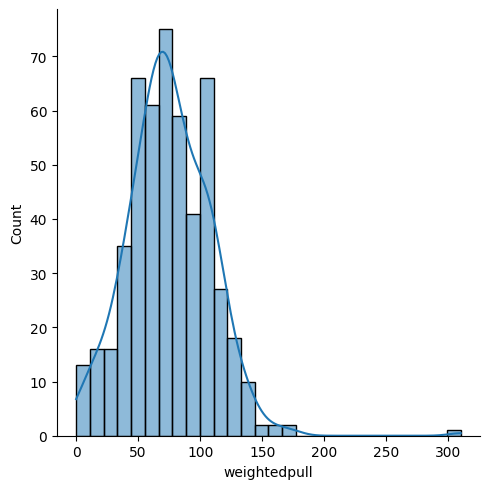

In [179]:
y = bouldering_only.weightedpull
sns.displot(y, kde=True)

# now we take a look at the outliers and zeros
maxpull_rows = bouldering_only[(bouldering_only.weightedpull == 0) | (bouldering_only.weightedpull > 150)]
maxpull_rows.head(50)

In [180]:
# we note again that row 465 doesn't allign well with their weightedpull and pullup numbers (310 lbs added is WR territory, but only 23 pullups?)
# seems like input was total weight rather than weight added, we adjust by subtracting by weight (124 lbs added for 23 pullups is much more in line)
bouldering_only.loc[(bouldering_only.weightedpull > 250), "weightedpull"] -= bouldering_only.loc[(bouldering_only.weightedpull > 250), "weight"]

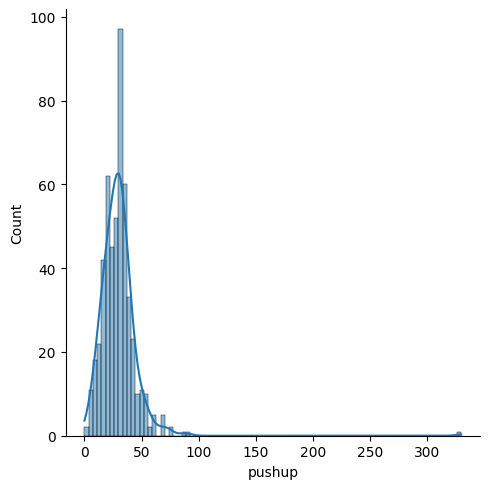

In [181]:
y = bouldering_only.pushup
sns.displot(y, kde=True)

pushup_rows = bouldering_only[bouldering_only.pushup > 200]
pushup_rows.head(50)

# seems like a fat finger, 30 pushups instead of 330
bouldering_only.loc[(bouldering_only.pushup > 200), "pushup"] -= 300

Now take a look at our data after initial cleaning

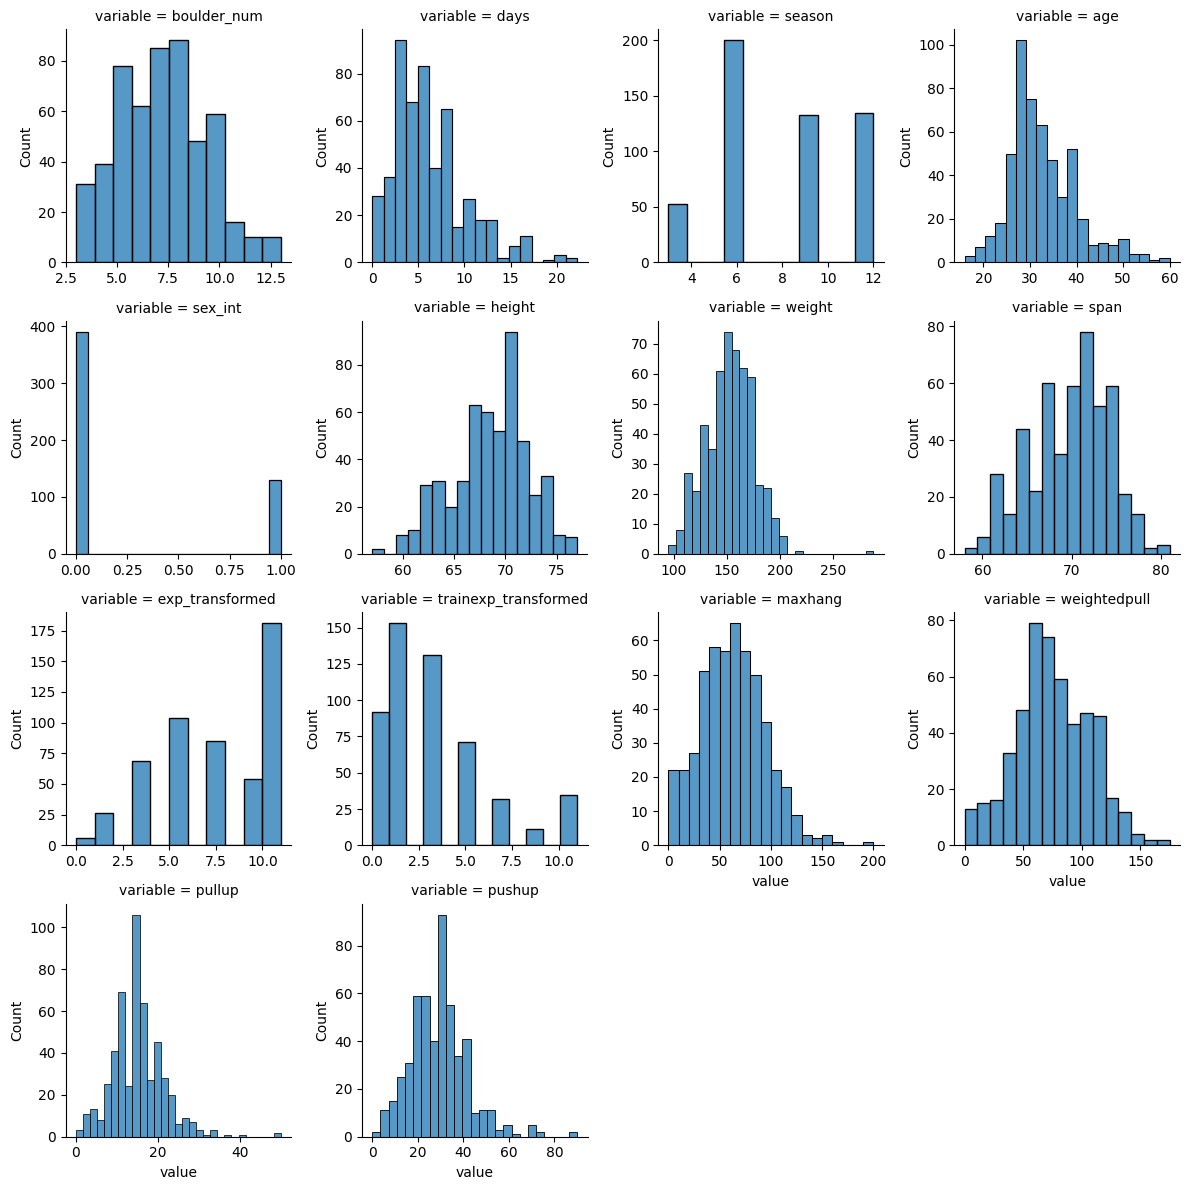

<Axes: >

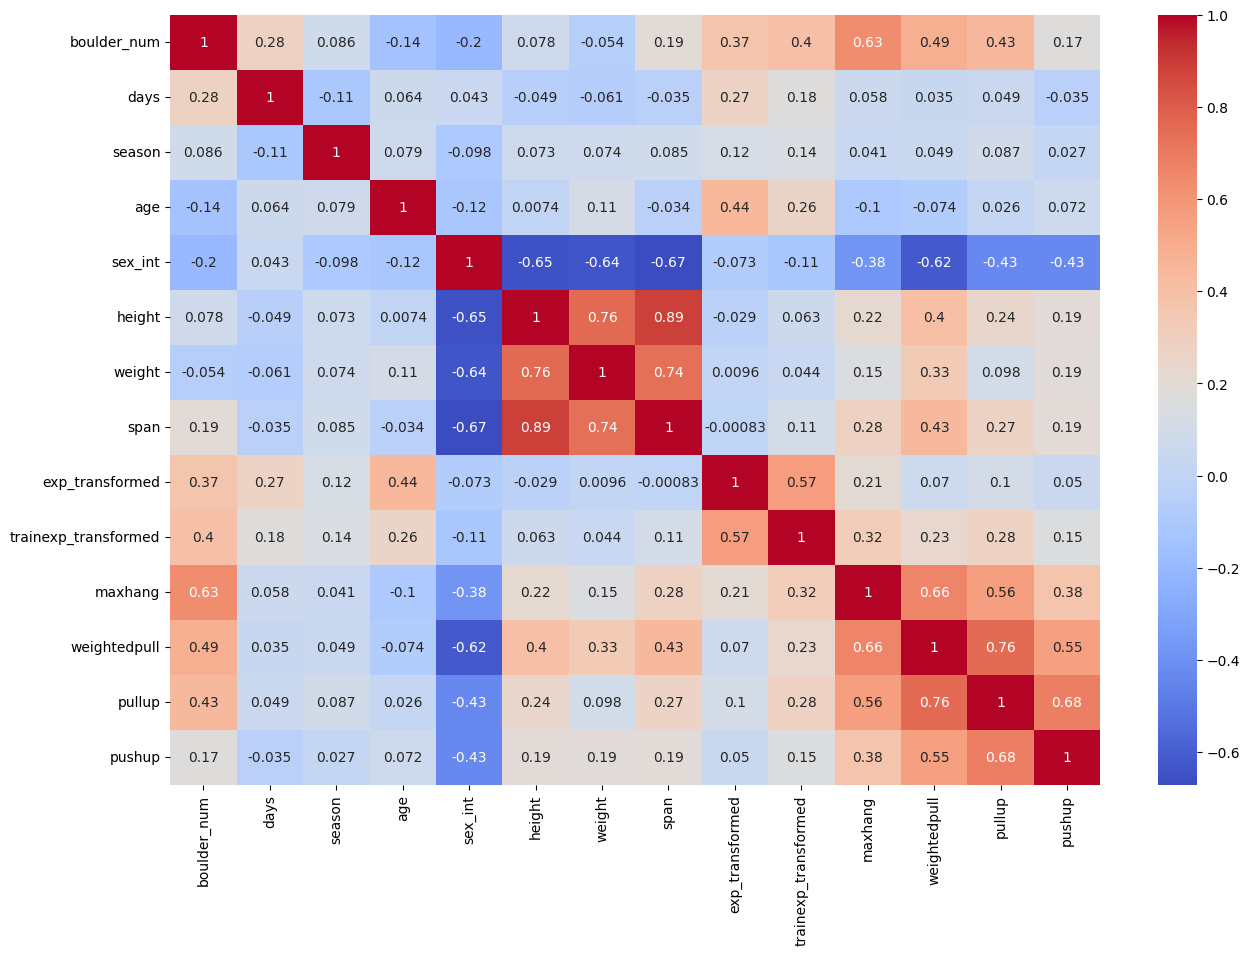

In [182]:
quant_feat = bouldering_only.columns.values

f = pd.melt(bouldering_only, value_vars=quant_feat)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")
plt.show()

plt.figure(figsize=(15, 10)).tight_layout()
sns.heatmap(bouldering_only.corr(numeric_only = True), annot=True, cmap='coolwarm')

#### Feature engineering
add new features

In [183]:
bouldering_only["ape"] = bouldering_only.span - bouldering_only.height
bouldering_only["hang_ratio"] = 1 + bouldering_only.maxhang / bouldering_only.weight
bouldering_only["pull_ratio"] = 1 + bouldering_only.weightedpull / bouldering_only.weight

Do more cleaning based on findings from new features

In [184]:
bouldering_only[bouldering_only.ape > 10]

,boulder_num,days,season,age,sex_int,height,weight,span,exp_transformed,trainexp_transformed,maxhang,weightedpull,pullup,pushup,ape,hang_ratio,pull_ratio
31,7.0,3.000000,6.0,40,0.0,61.5,155.0,75.6,11.0,5.0,54.0,54.0,12.0,25.0,14.1,1.348387,1.348387
176,10.0,6.666667,6.0,24,0.0,68.0,143.0,80.0,1.0,1.0,85.0,NaN,26.0,43.0,12.0,1.594406,NaN
556,6.0,2.222222,9.0,29,0.0,60.0,174.0,71.0,5.0,1.0,44.0,89.0,12.0,36.0,11.0,1.252874,1.511494


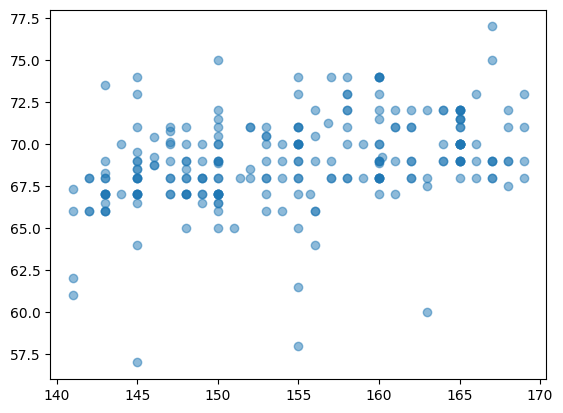

In [185]:
# apes over +10 are very odd. Note that a 5ft person weighing 174lbs (BMI of 34, obese) but also very in shape (good weighted pull, pushup) is extremely unlikely
# thus, the most likely story is that the height is wrong, rather than the other stats are wrong. Thus we null the height and the ape
bouldering_only.loc[(bouldering_only.ape == 11.0), "height"] = np.NaN
bouldering_only.loc[(bouldering_only.ape == 11.0), "ape"] = np.NaN

# this entry is also very improbable. An ape of over 1 foot is practically unheard of (Mo bamba has the highest in the NBA at 10.75in)
# taking a look at the below scatter plot, it seems like a weight of 155ish would correspond to about a 71.5in height, making me think there was a data entry error on the height
# thus, we NA the ape and height
plot_condition = (bouldering_only.weight > 140) & (bouldering_only.weight < 170)
plt.scatter(bouldering_only[plot_condition].weight, bouldering_only[plot_condition].height, alpha=0.5)
bouldering_only.loc[(bouldering_only.ape > 14), "height"] = np.NaN
bouldering_only.loc[(bouldering_only.ape > 14), "ape"] = np.NaN
# in this case, however, when we take a look at the height weight graph we see that a weight of 143 is typical of a height of 68in. 
# Therefore, this one likely entered span wrong instead of height
bouldering_only.loc[(bouldering_only.ape == 12.0), "span"] = np.NaN
bouldering_only.loc[(bouldering_only.ape == 12.0), "ape"] = np.NaN

Visualize our new features with the cleaned data

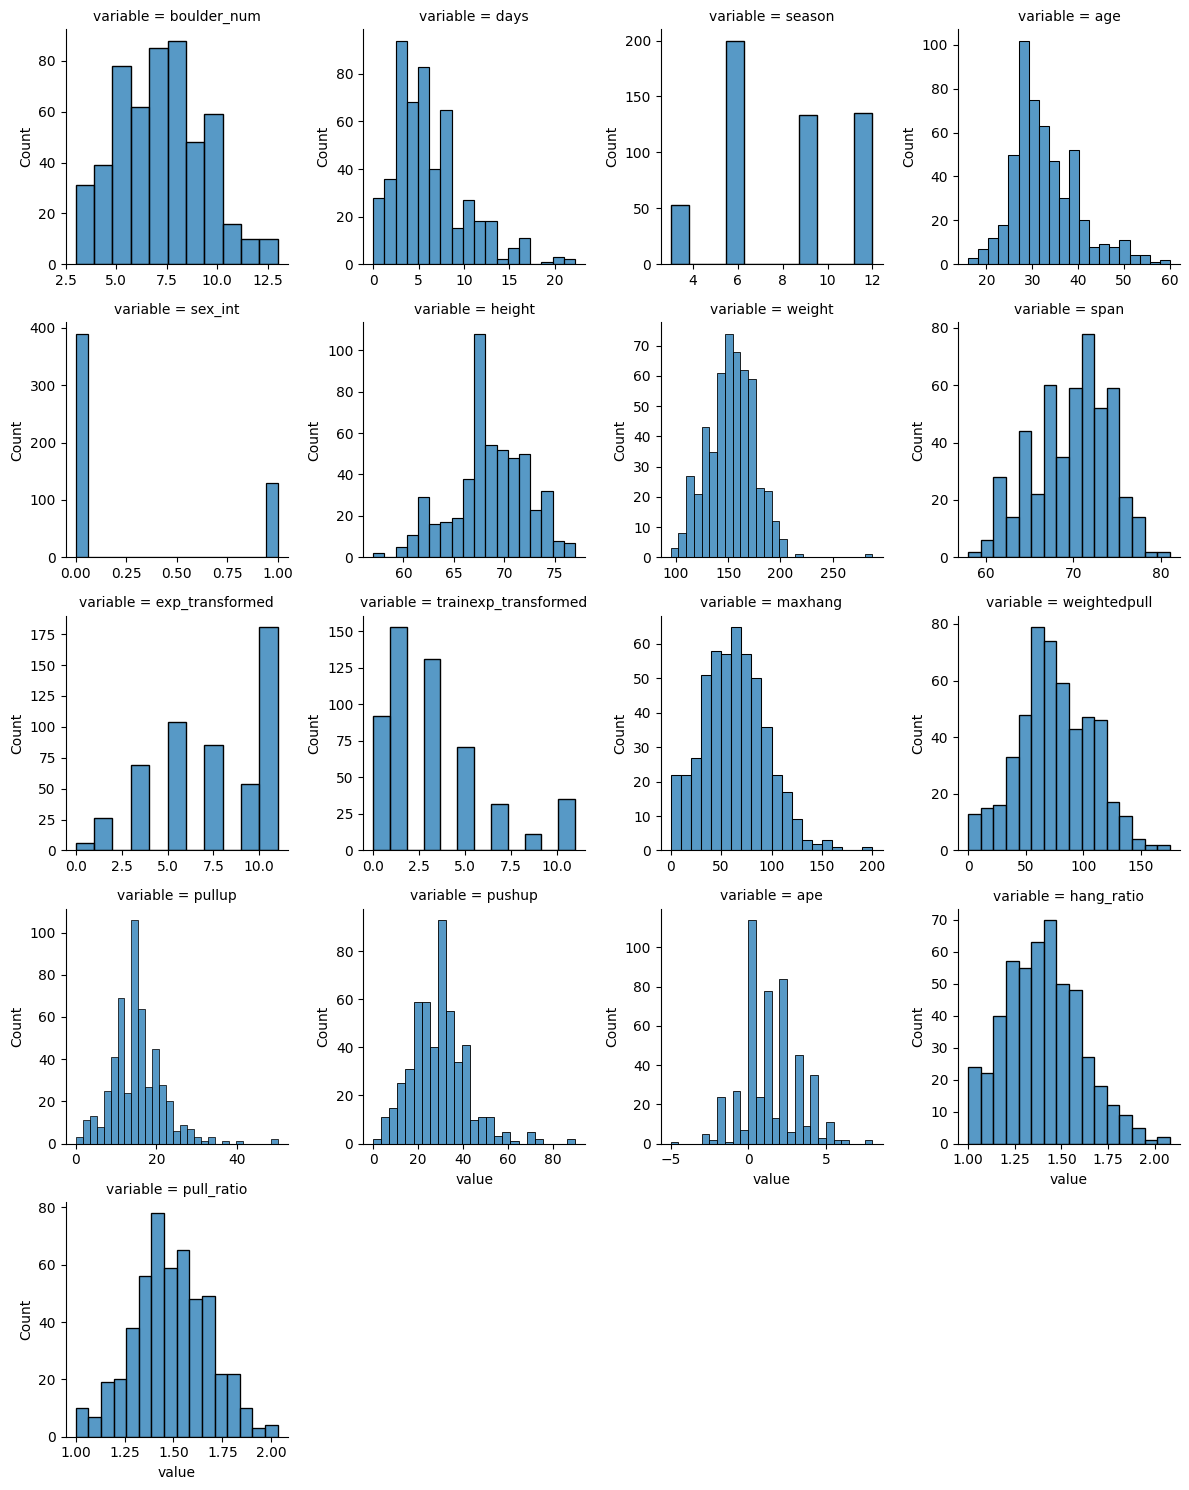

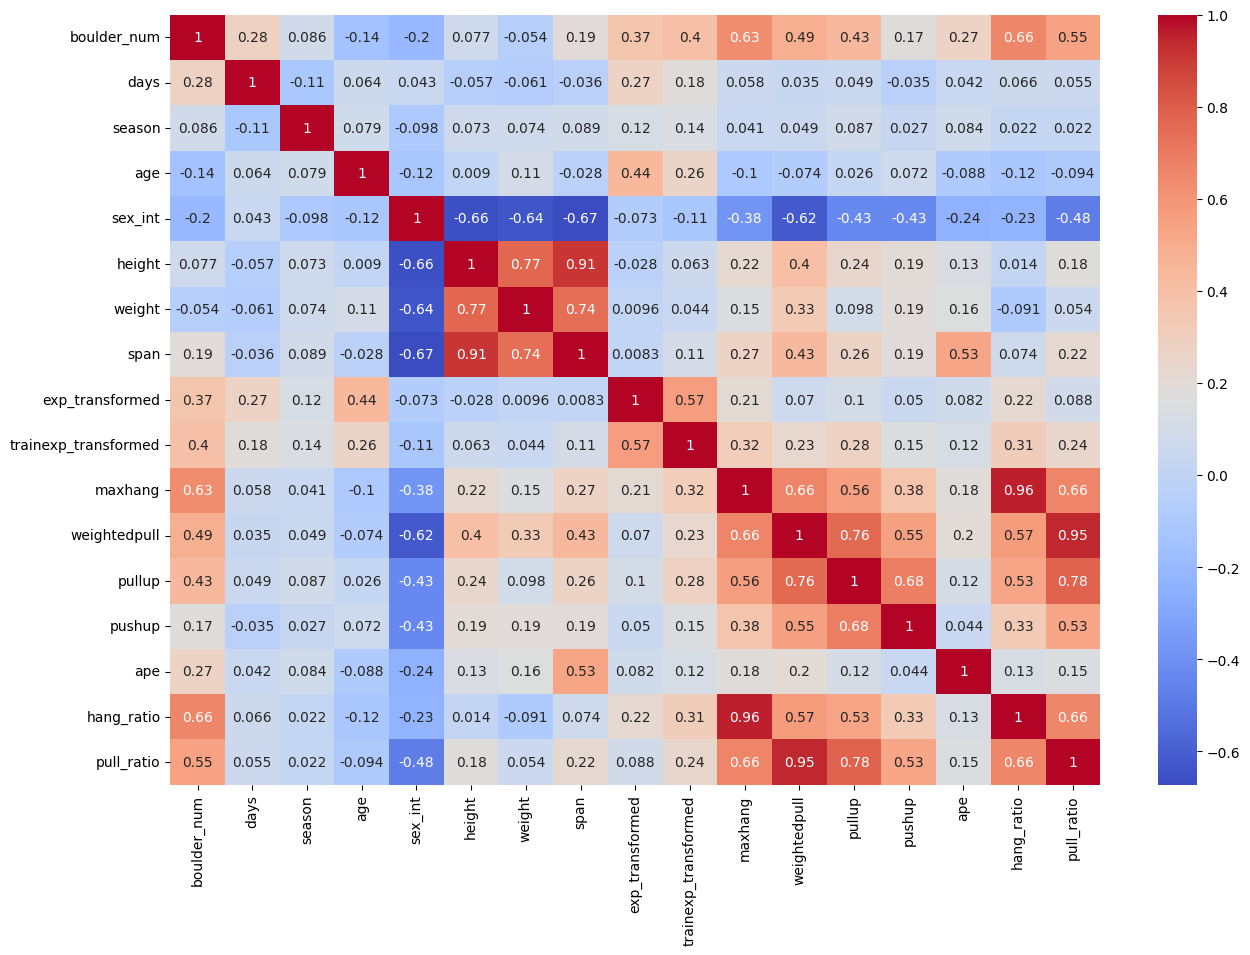

In [186]:
quant_feat = bouldering_only.columns.values

f = pd.melt(bouldering_only, value_vars=quant_feat)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")
plt.show()

plt.figure(figsize=(15, 10)).tight_layout()
sns.heatmap(bouldering_only.corr(numeric_only = True), annot=True, cmap='coolwarm')
plt.show()

Remove problems with the entire dataset (duplicates, too many nans, etc.), then save our preprocessed dataset

In [187]:
# dropping duplicates now, will look into fuzzy duplicate dropping
bouldering_only.drop_duplicates(keep="last", inplace=True) # we want to keep the most recent entry if there is a duplicate

# 3 or more nans in our used feature set (excluding some cols that calcs rely on) we will cull from the dataset, since imputing them is too fraught with error
imputable_list = ["age", "days", "exp_transformed", "trainexp_transformed", "hang_ratio", "pull_ratio", "ape"]
imputable_bouldering_only = bouldering_only.dropna(thresh=len(imputable_list) - 2, subset = imputable_list)

print(len(bouldering_only))
print(len(imputable_bouldering_only))

imputable_bouldering_only.to_csv("clean_power_company.csv", index=False)



514
512
